In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [3]:
train_path = "churn_train.csv"
test_path  = "churn_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train:", train_df.shape)
print("Test :", test_df.shape)

train_df.head()


Train: (5625, 24)
Test : (1407, 24)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_bucket,total_services,high_value,Churn
0,1830-GGFNM,Male,0,Yes,Yes,65,Yes,Yes,Fiber optic,Yes,...,No,Two year,No,Credit card (automatic),94.55,6078.75,49-72,2,1,0
1,4501-VCPFK,Male,0,No,No,26,No,No phone service,DSL,No,...,No,Month-to-month,No,Electronic check,35.75,1022.50,25-48,0,0,0
2,8871-JLMHM,Female,0,Yes,No,68,Yes,Yes,Fiber optic,No,...,No,Two year,No,Credit card (automatic),90.20,6297.65,49-72,1,1,0
3,0225-ZORZP,Male,0,No,No,3,Yes,No,Fiber optic,No,...,Yes,Month-to-month,No,Electronic check,84.30,235.05,0-12,2,1,0
4,1530-ZTDOZ,Female,0,Yes,No,49,No,No phone service,DSL,Yes,...,No,Month-to-month,No,Bank transfer (automatic),40.65,2070.75,49-72,2,0,0


In [4]:
def normalize_cols(df):
    df.columns = df.columns.str.strip().str.replace("\n", " ").str.replace("\r", " ")
    return df

train_df = normalize_cols(train_df)
test_df  = normalize_cols(test_df)

print(train_df.columns)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'tenure_bucket',
       'total_services', 'high_value', 'Churn'],
      dtype='object')


In [5]:
if "Churn" not in train_df.columns:
    possible = [c for c in train_df.columns if c.lower().strip().startswith("churn")]
    if possible:
        train_df = train_df.rename(columns={possible[0]: "Churn"})
        test_df = test_df.rename(columns={possible[0]: "Churn"})
    else:
        raise ValueError("Churn column NOT FOUND. Columns:", train_df.columns.tolist())

if train_df["Churn"].dtype == object:
    train_df["Churn"] = train_df["Churn"].map({"Yes":1, "No":0}).astype(int)
    test_df["Churn"]  = test_df["Churn"].map({"Yes":1, "No":0}).astype(int)

train_df["Churn"].value_counts()


Churn
0    4130
1    1495
Name: count, dtype: int64

In [6]:
X_train = train_df.drop("Churn", axis=1)
y_train = train_df["Churn"]

X_test  = test_df.drop("Churn", axis=1)
y_test  = test_df["Churn"]

print("X_train:", X_train.shape)
print("X_test :", X_test.shape)


X_train: (5625, 23)
X_test : (1407, 23)


In [7]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numerical:", num_cols)
print("Categorical:", cat_cols)


Numerical: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'total_services', 'high_value']
Categorical: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_bucket']


In [9]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

preprocessor.fit(X_train)


joblib.dump(preprocessor, "preprocessor.joblib")

print("Preprocessor saved.")


Preprocessor saved.


In [ ]:
lr_model = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:,1]

print("Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_prob_lr))

joblib.dump(lr_model, "logistic_pipeline.joblib")


In [16]:
rf_model = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=250,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("Random Forest")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, y_prob_rf))

joblib.dump(rf_model, "../src/rf_pipeline.joblib")


Random Forest
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1033
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.68      0.70      1407
weighted avg       0.77      0.78      0.77      1407

AUC: 0.8129170527667197


['../src/rf_pipeline.joblib']

In [17]:
results = {
    "Logistic Regression": roc_auc_score(y_test, y_prob_lr),
    "Random Forest": roc_auc_score(y_test, y_prob_rf)
}

results


{'Logistic Regression': 0.8340032924196695,
 'Random Forest': 0.8129170527667197}

In [20]:
best_model_name = max(results, key=results.get)

print("Best Model:", best_model_name)

model_files = {
    "Logistic Regression": "../src/logistic_pipeline.joblib",
    "Random Forest": "../src/rf_pipeline.joblib",
}

best_model_path = model_files[best_model_name]
best_model = joblib.load(best_model_path)


Best Model: Logistic Regression


In [21]:
y_prob_best = best_model.predict_proba(X_test)[:,1]
y_pred_best = best_model.predict(X_test)

output = X_test.copy()
output["actual_churn"] = y_test.values
output["predicted_churn"] = y_pred_best
output["churn_probability"] = y_prob_best

output = output.sort_values("churn_probability", ascending=False)

output.to_csv("../artifacts/high_risk_customers.csv", index=False)

output.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_bucket,total_services,high_value,actual_churn,predicted_churn,churn_probability
1149,Male,1,Yes,No,1,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,95.10,95.10,0-12,3,1,1,1,0.950326
211,Male,1,No,No,3,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,94.85,335.75,0-12,3,1,0,1,0.949303
591,Male,1,Yes,No,7,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,99.25,665.45,0-12,3,1,1,1,0.943658
902,Male,0,No,No,3,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,100.95,329.95,0-12,3,1,1,1,0.939100
1080,Female,1,No,No,1,Yes,Yes,Fiber optic,No,No,...,Yes,Electronic check,85.05,85.05,0-12,2,1,1,1,0.937590


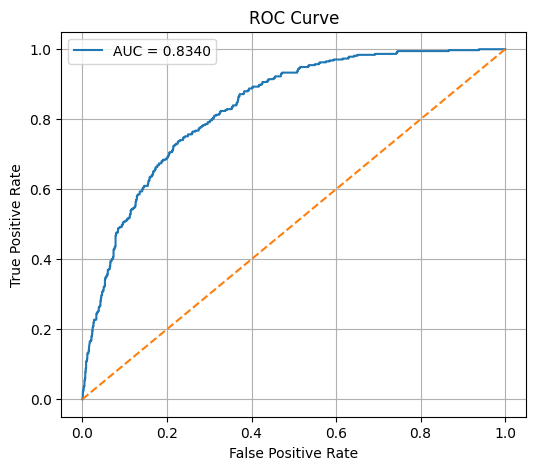

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()